In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
import numpy as np
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
import os
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
from scipy.stats import linregress
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/4XCO/outdata/oifs/links/']
input_names = ['4XCO']

ctrl_input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/oifs/links/']
ctrl_input_names = ['PICT']

climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
exps = range(1, 15)
figsize=(10, 10)
dpi = 300
var = ['TSR', 'TTR', 'T2M'] 
#var must have order:  
#1. Surface net solar radiation
#2. Surface net thermal radiation
#3. Top net solar radiation
#4. Top net thermal radiation

In [3]:
# Load model Data

data = OrderedDict()
for v in var:
    paths = []
    data[v] = []
    for exp in tqdm.tqdm(exps):
        path = input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
        data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v)/accumulation_period)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [03:05<00:00, 13.26s/it]


In [4]:
ctrl_data = OrderedDict()
for v in var:
    paths = []
    ctrl_data[v] = []
    for exp in tqdm.tqdm(range(1, 10)):
        path = ctrl_input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
        ctrl_data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v)/accumulation_period)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:52<00:00, 19.13s/it]


In [5]:
t2m = (np.squeeze(np.vstack(data['T2M']))-np.mean(np.squeeze(np.vstack(ctrl_data['T2M']))))*accumulation_period
toa = np.squeeze(np.vstack(data['TTR']))+np.squeeze(np.vstack(data['TSR']))-np.mean((np.squeeze(np.vstack(ctrl_data['TTR']))+np.squeeze(np.vstack(ctrl_data['TSR']))))

In [6]:
np.mean((np.squeeze(np.vstack(ctrl_data['TTR']))+np.squeeze(np.vstack(ctrl_data['TSR']))))

-0.047109246

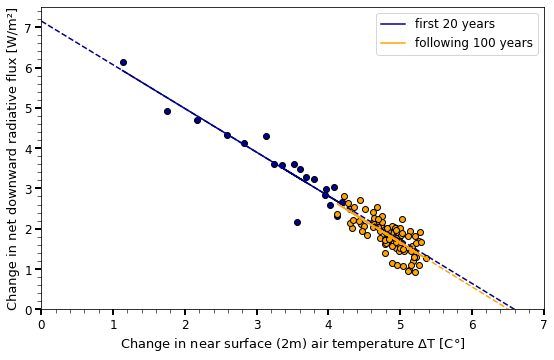

In [10]:

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)



splitval=20
res1 = linregress(t2m[0:splitval-1],toa[0:splitval-1])
res2 = linregress(t2m[splitval:119],toa[splitval:119])

fig, ax = plt.subplots(figsize=(9,5.56))

plt.scatter(t2m[0:splitval-1],toa[0:splitval-1],color='darkblue',edgecolors= "black")
plt.scatter(t2m[splitval:119],toa[splitval:119],color='orange',edgecolors= "black")
plt.plot(t2m[0:splitval-1], res1.intercept + res1.slope*t2m[0:splitval-1], 'darkblue', label='first 20 years')
plt.plot(t2m[splitval:119], res2.intercept + res2.slope*t2m[splitval:119], 'orange', label='following 100 years')

#plt.text(2.5,5,'slope:'+str(np.round(res2.slope,3)),color='blue',fontsize=14)
#plt.text(2.5,1.2,'slope:'+str(np.round(res1.slope,3)),color='orange',fontsize=14)


plt.ylim(ymax = 7.5, ymin = 0)
plt.xlim(xmax = 7, xmin = 0)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.tick_params(direction='out', length=6, width=2,
               grid_color='r', grid_alpha=0.5)
ax = plt.gca()

x_vals = np.array((0,7.5))
y_vals = res1.intercept + res1.slope * x_vals
plt.plot(x_vals, y_vals, '--',color='darkblue')

x_vals = np.array((4.5,7))
y_vals = res2.intercept + res2.slope * x_vals
plt.plot(x_vals, y_vals, '--',color='orange')


plt.legend(loc='upper right')

plt.ylabel('Change in net downward radiative flux [W/m²]',fontsize=13)
plt.xlabel('Change in near surface (2m) air temperature $\Delta$T [C°]',fontsize=13)

plt.savefig('gregory_plot.png', dpi=dpi)
